# Dog Breed Classifier Project

## 2. Making predictions with a pretrained model

We will import a pretrained convolutional network to see how well it performs on pictures of dogs, including Korean Jindo dogs.

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import os.path

In [3]:
# Import the pretrained CNN 'ResNet50'
model = tf.keras.applications.resnet50.ResNet50()

In [4]:
# Visualize the different layers
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [4]:
# Size of images that will be fed to the network
IMG_WIDTH, IMG_HEIGHT = 224, 224

We will pick a few random pictures from the dataset and see what the pretrained model says about them.  
We query only the top 2 guesses, i.e. the 2 predictions with highest probability.  
'Ground truth' is the actual breed of the dog, based on the folder name in which the picture is stored.  
The 1,000 categories (including 189 breeds of dogs) on which ResNet-50 was trained differ from the categories in our dataset, therefore the prediction and ground truth might not match.

In [5]:
# Function to randomly select, pre-process pictures from a PATH and run the model to make predictions on those pictures
def pick_pictures(path, columns, rows):
    # Create a matplotlib figure
    fig=plt.figure(figsize=(20, 12))
    ax = []
    
    # Browse files in the PATH directory
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(path):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    
    # Randomly pick a certain number of pictures from the list
    files = random.sample(range(len(listOfFiles)), columns*rows)
    
    for i in range(columns*rows):
        # Transform each image into a Tensor
        img = image.load_img(listOfFiles[files[i]], target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        
        # Get predictions from the model
        prediction = model.predict(img_preprocessed)
        
        # Retrieve the label and probability for the top two guesses
        prob = decode_predictions(prediction, top=2)
        
        # Plot the results in an ordered fashion
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("Probably a {}".format(prob[0][0][1] +
                         "\n({:.2f} % chance)".format(prob[0][0][2]*100)) +
                         "\n\nPossibly a {}".format(prob[0][1][1] +
                         "\n({:.2f} % chance)".format(prob[0][1][2]*100)) +
                         "\n\nGround truth: {}".format(listOfFiles[files[i]].split("/")[2].split(".")[1].split("\\")[0])
                        )

        plt.axis('off')
        plt.imshow(img)

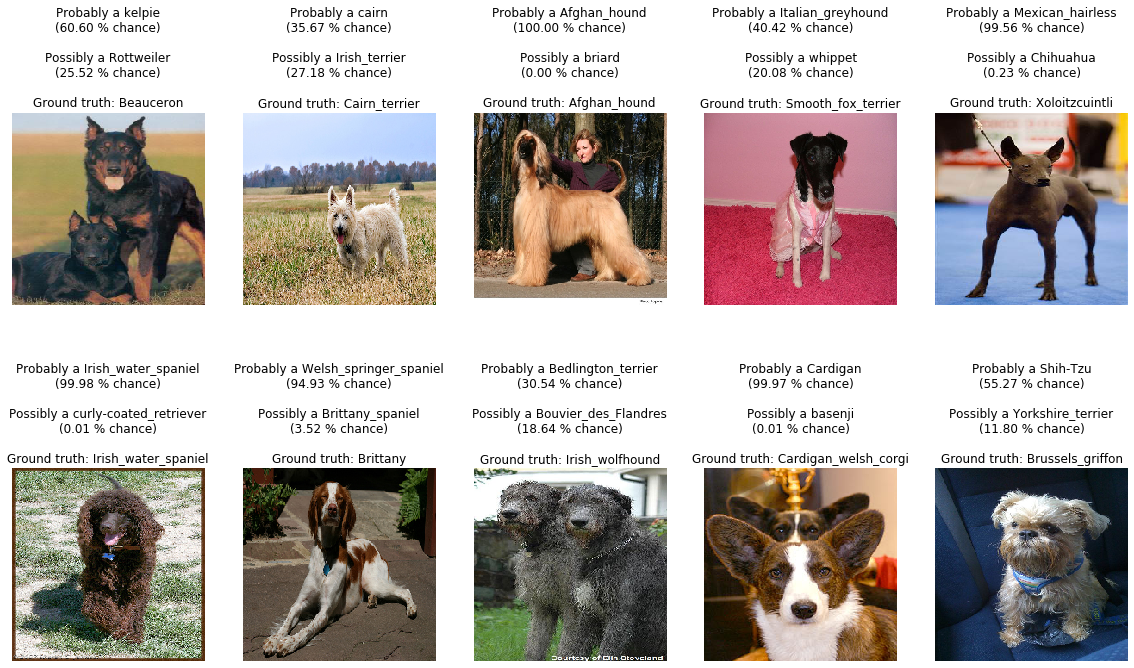

In [10]:
# Run the function on the test dataset, for a total of 10 pictures
PATH = 'images/test/'
COLUMNS = 5
ROWS = 2

pick_pictures(PATH, COLUMNS, ROWS)

Let's narrow the images to Korean Jindo dogs (Ground truth = Korean jindo).  
Since this breed is not present in the original ResNet categories, none of the predictions matches.  
In the next notebook, we will retrain the model to take into consideration this particular breed.  
For now, let's see how the ResNet model interprets Jindo dogs.

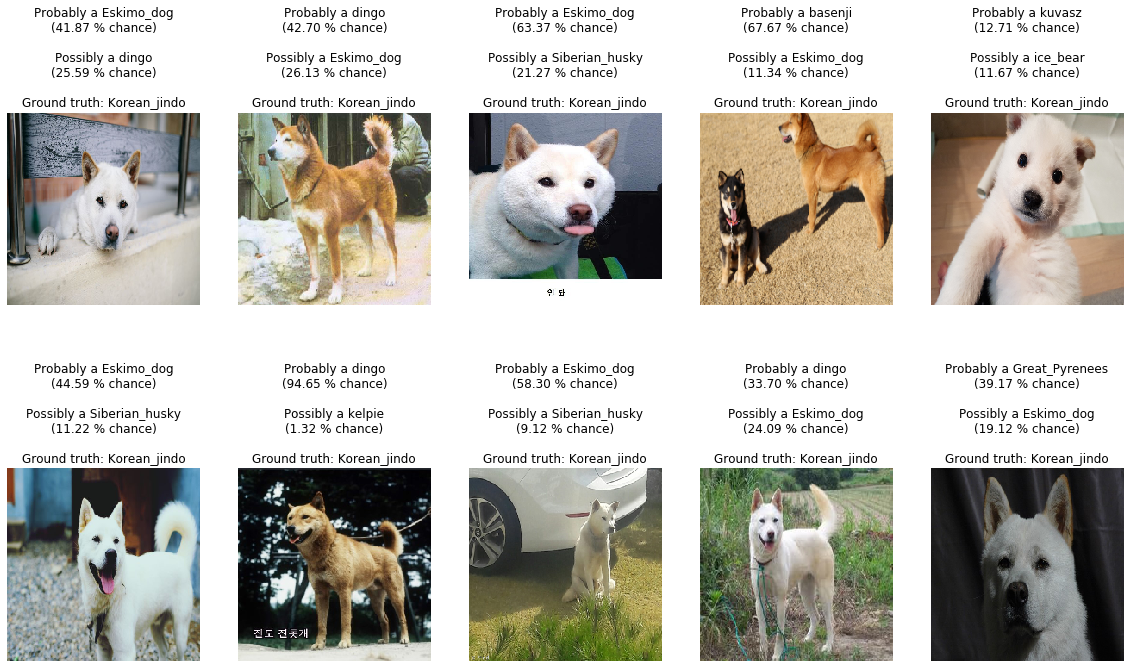

In [12]:
# Run the function on the Korean Jindo dogs from the test dataset, for a total of 10 pictures
PATH = 'images/test/134.Korean_jindo'
COLUMNS = 5
ROWS = 2

pick_pictures(PATH, COLUMNS, ROWS)

The model identified a lot of Dingoes and Eskimo dogs.  
Let's get the predictions from ResNet-50 on all Jindo dog pictures contained in the training set and see what breeds come most often.

In [11]:
files = list() # List of files to be retrieved from the directory
top_predictions = []

# Go through Jindo dog pictures in the training dataset
for (dirpath, dirnames, filenames) in os.walk('images/train/134.Korean_jindo'):
    files += [os.path.join(dirpath, file) for file in filenames]

# Pre-process each file retrieved and feed it to the model to get a prediction
for i in files:
    # Transform each image into a Tensor
    img = image.load_img(i, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    
    # Get predictions from the model
    prediction = model.predict(img_preprocessed)
    prob = decode_predictions(prediction, top=1)
    
    # Add the top prediction (class with highest probability) to the list of predictions
    top_predictions.append(prob[0][0][1])

In [12]:
from collections import Counter
Counter(top_predictions).most_common()

[('Eskimo_dog', 27),
 ('dingo', 20),
 ('kuvasz', 13),
 ('Samoyed', 6),
 ('chow', 5),
 ('basenji', 5),
 ('Ibizan_hound', 4),
 ('Pembroke', 3),
 ('Tibetan_mastiff', 3),
 ('white_wolf', 2),
 ('Great_Pyrenees', 2),
 ('Labrador_retriever', 2),
 ('ice_bear', 2),
 ('borzoi', 2),
 ('Irish_wolfhound', 2),
 ('Norwegian_elkhound', 1),
 ('kelpie', 1),
 ('Irish_terrier', 1),
 ('Rhodesian_ridgeback', 1),
 ('clumber', 1),
 ('dhole', 1),
 ('Staffordshire_bullterrier', 1),
 ('collie', 1),
 ('standard_poodle', 1),
 ('German_shepherd', 1),
 ('dogsled', 1),
 ('West_Highland_white_terrier', 1),
 ('prison', 1),
 ('pedestal', 1),
 ('schipperke', 1),
 ('wire-haired_fox_terrier', 1),
 ('red_wolf', 1)]

The ResNet clearly tends to identify Jindo dogs as Eskimo dogs or Dingoes.  
They are indeed very similar. Note that Eskimos and Jindos are both from the same 'spitz' family.

![title](jindo-dingo-eskimo.jpg)